In [1]:
# from tensorflow_docs.vis import embed
import tensorflow as tf
import numpy as np
import imageio
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import imgaug.augmenters as iaa
import random
import cv2
from sklearn.model_selection import StratifiedKFold
from self_htr import Self_HTR


In [2]:
aug = False
plot = True if not aug else False

In [3]:
random_state = 42
random.seed(random_state)

aug_seq = iaa.Sequential([
            iaa.Rotate((-10, 10), random_state=random_state),                 
            iaa.ShearX((-10, 10), random_state=random_state),                  
            iaa.ShearY((-10, 10), random_state=random_state),
        ])

def augment(image):
    kernel = np.ones((2, 2), np.uint8) 
    if random.random() < 0.5:
        image = cv2.erode(image, kernel, iterations=1) 
    else:
        image = cv2.dilate(image, kernel, iterations=1) 
    image = aug_seq.augment_image(image)
    return image

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_total_data = np.concatenate([x_train, np.array(x_test)])
y_total_data = np.concatenate([y_train, y_test])


x_train, gan_train, y_train, gan_y_train = train_test_split(x_train, y_train, test_size=0.5, random_state=42)

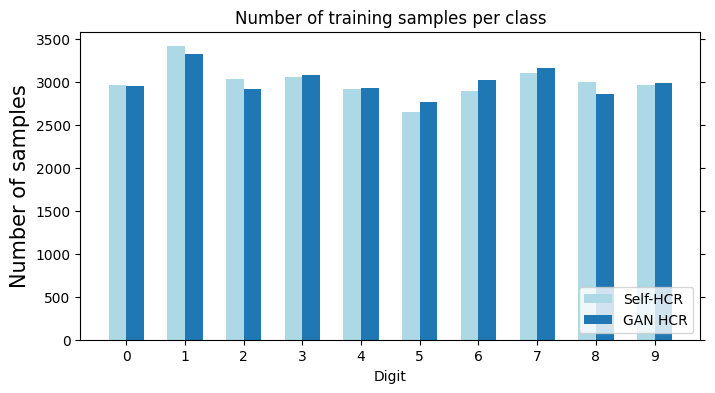

[6903 7877 6990 7141 6824 6313 6876 7293 6825 6958]


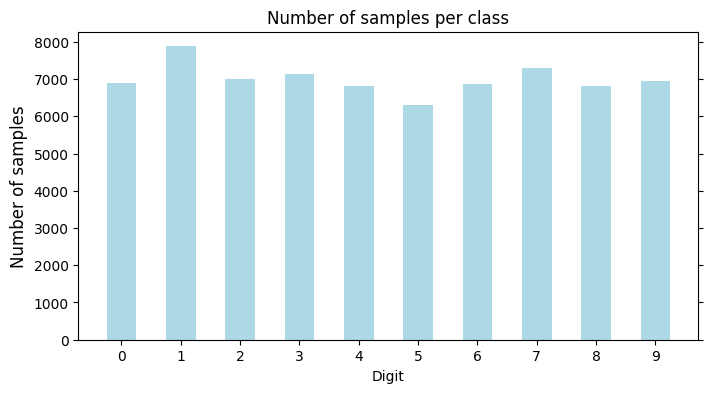

In [6]:
if plot:
	plt.rcParams['figure.figsize'] = [8, 4]
	fig, ax = plt.subplots(nrows=1, ncols=1)

	_, train_counts = np.unique(y_train, return_counts=True)
	_, gan_train_counts = np.unique(gan_y_train, return_counts=True)

	barWidth = 0.3
	br1 = np.arange(len(train_counts)) 
	br2 = [x + barWidth for x in br1] 

	ax.bar(br1, train_counts, width=barWidth, color='lightblue', label="Self-HCR")
	ax.bar(br2, gan_train_counts, width=barWidth, label="GAN HCR")
	# ax.set_xticklabels(labels=[i for i in range(10)])
	ax.tick_params(left = True, right = True , labelleft = True , 
					labelbottom = True, bottom = True) 
	plt.xticks([r + (barWidth/2) for r in range(len(train_counts))], 
			['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
	plt.ylabel('Number of samples', fontsize = 15) 
	plt.xlabel('Digit')
	plt.title('Number of training samples per class')
	plt.legend(loc="lower right")
	plt.savefig('./datavis/classbal_mnist_training.png', dpi=300)
	plt.show()

	plt.rcParams['figure.figsize'] = [8, 4]
	fig, ax = plt.subplots(nrows=1, ncols=1)

	_, total_counts = np.unique(y_total_data, return_counts=True)
	print(total_counts)

	barWidth = 0.5
	br1 = np.arange(len(train_counts)) 

	ax.bar(br1, total_counts, width=barWidth, color='lightblue')
	# ax.set_xticklabels(labels=[i for i in range(10)])
	ax.tick_params(left = True, right = True , labelleft = True , 
					labelbottom = True, bottom = True) 
	plt.xticks([r for r in range(len(train_counts))], 
			['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
	plt.ylabel('Number of samples', fontsize = 12) 
	plt.xlabel('Digit')
	plt.title('Number of samples per class')
	plt.savefig('./datavis/classbal_mnist.png', dpi=300)
	plt.show()


### Checking the data

In [6]:
if plot:
	tsne = TSNE(n_components=2)
	tsne_results = tsne.fit_transform(x_total_data.reshape(x_total_data.shape[0], 28*28))

	# x_train_tsne_results = tsne.fit_transform(x_train.reshape(x_train.shape[0], 28*28))
	# gan_train_tsne_results = tsne.fit_transform(gan_train.reshape(gan_train.shape[0], 28*28))



In [7]:
def plot_tsne(results, y_data, file_name):
	plt.rcParams['figure.figsize'] = [20, 15]
	fig = plt.figure()
	scatter = plt.scatter(results[:,0], results[:,1], c=y_data)
	handles, _ = scatter.legend_elements(prop='colors')
	plt.legend(handles, np.unique(y_total_data), prop = { "size": 20 }, loc="upper right")
	plt.title("t-SNE MNIST", fontsize=30)
	plt.xlabel("First t-SNE", fontsize=20)
	plt.ylabel("Second t-SNE", fontsize=20)
	plt.yticks(fontsize=20)
	plt.xticks(fontsize=20)
	plt.savefig(file_name, dpi=300)
	plt.show()


In [ ]:
if plot:
	plot_tsne(tsne_results, y_total_data, "./datavis/mnist_tsne.png")
	


In [18]:
if aug:
    x_train_aug = np.array([augment(x) for x in x_train.astype("float32")])
    x_train = np.concatenate([x_train, np.array(x_train_aug)])
    y_train = np.concatenate([y_train, y_train])

x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))


x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))
y_test = tf.keras.utils.to_categorical(y_test, 10)


In [5]:
def make_htr_model():
    initializer = tf.keras.initializers.HeUniform(seed=42)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1],  kernel_initializer=initializer))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3, seed=42))
    
    model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1],  kernel_initializer=initializer))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3, seed=42))

    model.add(tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same',  kernel_initializer=initializer))
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(10,  kernel_initializer=initializer))
    model.add(tf.keras.layers.Softmax())
    return model

# Supervised Handwritten character Recognition

In [7]:
super_htr_model = make_htr_model()    
super_htr_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         7

In [12]:
epochs = 100
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

super_htr_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['acc'],
)

res = {}
preds = {}

skf = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
for i, (train_index, valid_index) in enumerate(skf.split(x_train, y_train)):
    print("Starting fold ", i)
    x_train_fold = [x_train[i] for i in train_index]
    x_valid_fold = [x_train[i] for i in valid_index]

    y_train_fold = [y_train[i] for i in train_index]
    y_valid_fold = [y_train[i] for i in valid_index]

    y_train_fold = tf.keras.utils.to_categorical(y_train_fold, 10)
    y_valid_fold = tf.keras.utils.to_categorical(y_valid_fold, 10)

    dataset = tf.data.Dataset.from_tensor_slices((x_train_fold, y_train_fold))
    dataset = dataset.shuffle(buffer_size=1024).batch(256)

    val_dataset = tf.data.Dataset.from_tensor_slices((x_valid_fold, y_valid_fold))
    val_dataset = val_dataset.batch(256)

    super_htr_model = make_htr_model()    
    super_htr_model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss='categorical_crossentropy',
        metrics=['acc'],
    )
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    res[i] = super_htr_model.fit(dataset, epochs=epochs, validation_data=val_dataset, callbacks=[callback])
    preds = super_htr_model.predict(x_test)

    super_htr_model.save(f'./mnist_super_hcr_f{i}.keras')

Starting fold  0
Epoch 1/100
79/79 [==============================] - 8s 16ms/step - loss: 0.5095 - acc: 0.8447 - val_loss: 0.2553 - val_acc: 0.9264
Epoch 2/100
79/79 [==============================] - 1s 12ms/step - loss: 0.2227 - acc: 0.9331 - val_loss: 0.1640 - val_acc: 0.9533
Epoch 3/100
79/79 [==============================] - 1s 12ms/step - loss: 0.1563 - acc: 0.9529 - val_loss: 0.1202 - val_acc: 0.9648
Epoch 4/100
79/79 [==============================] - 1s 12ms/step - loss: 0.1275 - acc: 0.9614 - val_loss: 0.1254 - val_acc: 0.9627
Epoch 5/100
79/79 [==============================] - 1s 12ms/step - loss: 0.1150 - acc: 0.9638 - val_loss: 0.0931 - val_acc: 0.9730
Epoch 6/100
79/79 [==============================] - 1s 12ms/step - loss: 0.0951 - acc: 0.9703 - val_loss: 0.0897 - val_acc: 0.9736
Epoch 7/100
79/79 [==============================] - 1s 12ms/step - loss: 0.0926 - acc: 0.9693 - val_loss: 0.0900 - val_acc: 0.9724
Epoch 8/100
79/79 [==============================] - 1s 12m

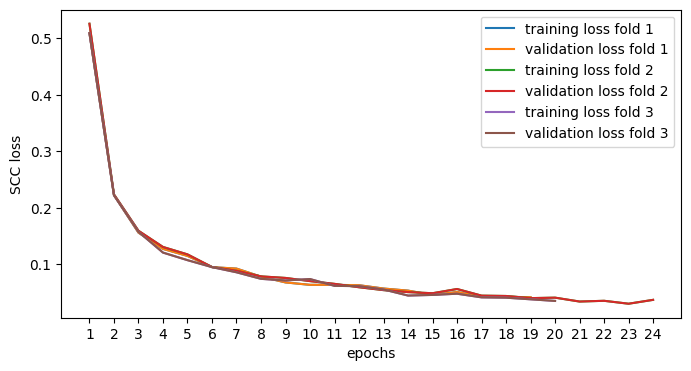

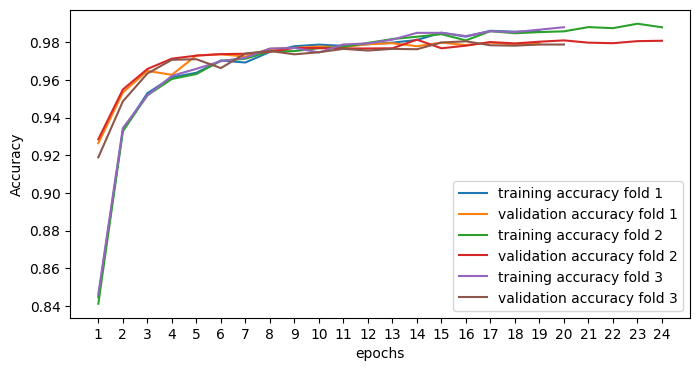

In [13]:
tr_loss = []
val_loss = []

tr_acc = []
val_acc = []

for i in range(len(res.keys())):
	tr_loss.append(list(res[i].history['loss']))
	val_loss.append(list(res[i].history['loss']))

	tr_acc.append(list(res[i].history['acc']))
	val_acc.append(list(res[i].history['val_acc']))


fig = plt.figure(figsize=(8, 4))

max_epochs = max(len(tr_loss[0]), len(tr_loss[1]), len(tr_loss[2]))
plt.plot(np.arange(len(tr_loss[0])), tr_loss[0], label="training loss fold 1")
plt.plot(val_loss[0], label="validation loss fold 1")
plt.plot(np.arange(len(tr_loss[1])),tr_loss[1],  label="training loss fold 2")
plt.plot(val_loss[1], label="validation loss fold 2")
plt.plot(np.arange(len(tr_loss[2])), tr_loss[2],  label="training loss fold 3")
plt.plot(val_loss[2], label="validation loss fold 3")
plt.plot(np.arange(len(tr_loss[3])), tr_loss[3],  label="training loss fold 4")
plt.plot(val_loss[2], label="validation loss fold 4")
plt.plot(np.arange(len(tr_loss[4])), tr_loss[4],  label="training loss fold 5")
plt.plot(val_loss[2], label="validation loss fold 5")
plt.legend()
plt.xticks(np.arange(0, max_epochs), labels = np.arange(1, max_epochs + 1))
plt.xlabel("epochs")
plt.ylabel("SCC loss")
if aug:
	plt.savefig("./results/super_hcr_loss_aug.png", dpi=300)
else:
	plt.savefig("./results/super_hcr_loss.png", dpi=300)
plt.show()


fig = plt.figure(figsize=(8, 4))

max_epochs = max(len(tr_acc[0]), len(tr_acc[1]), len(tr_acc[2]))
plt.plot(np.arange(len(tr_acc[0])), tr_acc[0], label="training accuracy fold 1")
plt.plot(val_acc[0], label="validation accuracy fold 1")
plt.plot(np.arange(len(tr_acc[1])),tr_acc[1],  label="training accuracy fold 2")
plt.plot(val_acc[1], label="validation accuracy fold 2")
plt.plot(np.arange(len(tr_acc[2])), tr_acc[2],  label="training accuracy fold 3")
plt.plot(val_acc[2], label="validation accuracy fold 3")
plt.plot(np.arange(len(tr_acc[3])), tr_acc[3],  label="training accuracy fold 4")
plt.plot(val_acc[2], label="validation accuracy fold 4")
plt.plot(np.arange(len(tr_acc[4])), tr_acc[4],  label="training accuracy fold 5")
plt.plot(val_acc[2], label="validation accuracy fold 5")
plt.legend()
plt.xticks(np.arange(0, max_epochs), labels = np.arange(1, max_epochs + 1))
plt.xlabel("epochs")
plt.ylabel("Accuracy")
if aug:
	plt.savefig("./results/super_hcr_acc_aug.png", dpi=300)
else:
	plt.savefig("./results/super_hcr_acc.png", dpi=300)
plt.show()

313/313 [==============================] - 0s 1ms/step
(10000, 10)
Test accuracy: 0.9864


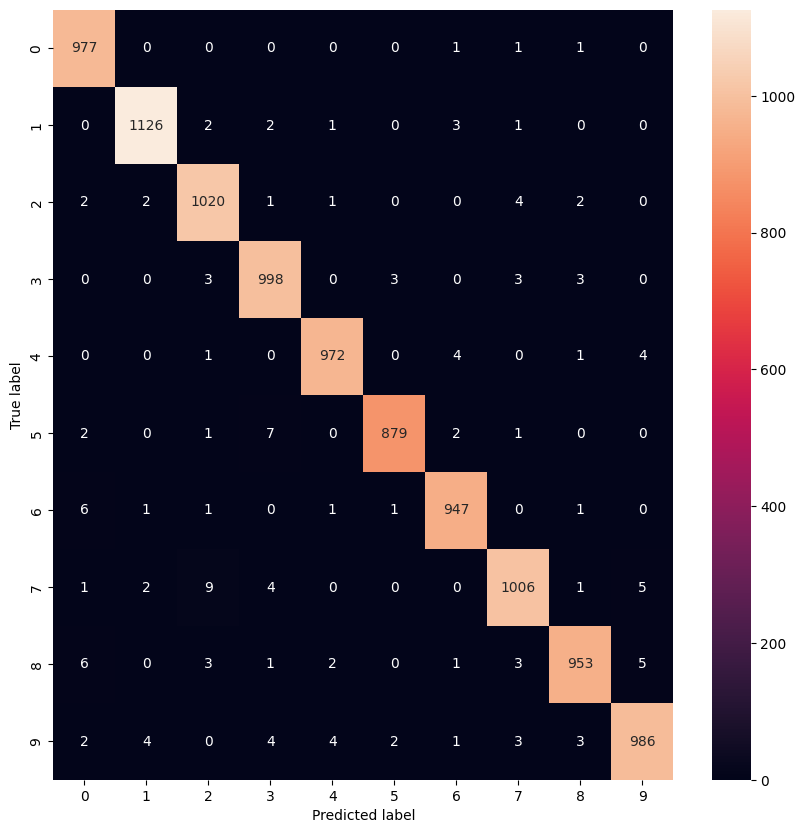

In [14]:
y_pred = np.mean([preds[i] for i in range(len(preds.keys()))], axis=0)
print(y_pred.shape)

y_pred = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test, axis = 1)

accuracy = accuracy_score(y_true, y_pred)
conf_mat = confusion_matrix(y_true, y_pred)

print("Test accuracy:", accuracy)

fig = plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='g')
plt.ylabel("True label")
plt.xlabel("Predicted label")
if aug:
	plt.savefig('super_hcr_confmat_aug.png')
plt.show()

# Self-supervised handwritten character recognition

### Plotting vgg features

In [6]:
def get_vgg_model(n_layer, summary=False):
	model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3), pooling=None)
	if summary:
		for num, layer in enumerate(model.layers):
			print(num, layer)
	input_data = tf.keras.Input(shape=(28, 28, 3))
	resized_input = tf.keras.layers.Resizing(32, 32)(input_data)
	desired_layer_output = tf.keras.models.Sequential(model.layers[:n_layer])(resized_input)
	vgg_model = tf.keras.Model(inputs=input_data, outputs=desired_layer_output)
	if summary:
		vgg_model.summary()
	return vgg_model


In [19]:
vgg_model = get_vgg_model(3, summary=True)

0 <keras.engine.input_layer.InputLayer object at 0x000001B1AC430F70>
1 <keras.layers.convolutional.conv2d.Conv2D object at 0x000001B1E78997E0>
2 <keras.layers.convolutional.conv2d.Conv2D object at 0x000001B1E7DDBB50>
3 <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001B1AC39BC70>
4 <keras.layers.convolutional.conv2d.Conv2D object at 0x000001B1AC430B80>
5 <keras.layers.convolutional.conv2d.Conv2D object at 0x000001B198D045B0>
6 <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001B1E7D968F0>
7 <keras.layers.convolutional.conv2d.Conv2D object at 0x000001B1DDFF98D0>
8 <keras.layers.convolutional.conv2d.Conv2D object at 0x000001B1DDFF9000>
9 <keras.layers.convolutional.conv2d.Conv2D object at 0x000001B1E7D97040>
10 <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001B1DE0C0880>
11 <keras.layers.convolutional.conv2d.Conv2D object at 0x000001B1DE0C3A00>
12 <keras.layers.convolutional.conv2d.Conv2D object at 0x000001B0014CD210>
13 <keras.layers.co

In [9]:
# x_total_data = np.concatenate([x_train, x_val])
# y_total_data = np.concatenate([np.argmax(y_train, axis=1), np.argmax(y_val, axis=1)])

# print(len(x_total_data))

total_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
total_dataset = total_dataset.shuffle(buffer_size=1024).batch(1024)

# layers = [5, 6, 8, 9, 10, 12, 13, 14, 16, 17, 18]
# layers = [12, 13, 14, 16, 17, 18]

# for layer in layers:
layer = 18
print("convolution:", layer)
vgg_features = []
label_batches = []

vgg_model = get_vgg_model(layer)

for batch in total_dataset:
	images, labels = batch
	images_in = tf.concat([images] * 3, axis=-1)
	feats = vgg_model(images_in)
	feats = tf.reshape(feats, [tf.shape(feats)[0], -1]).numpy()
	vgg_features += feats.tolist()
	label_batches += labels.numpy().tolist()

print("computed features, starting tsne...")

if plot:
	tsne = TSNE(n_components=2)
	vgg_tsne_results = tsne.fit_transform(np.array(vgg_features))

	print("Finished tsne dimensionality reduction")

	plt.rcParams['figure.figsize'] = [20, 15]
	fig = plt.figure()
	scatter = plt.scatter(vgg_tsne_results[:,0], vgg_tsne_results[:,1], c=label_batches)
	handles, _ = scatter.legend_elements(prop='colors')
	plt.legend(handles, np.unique(label_batches), prop = { "size": 15 }, loc="upper right")
	plt.title(f"Self-HCR dataset vgg features {layer}th convolution", fontsize=20)
	plt.xlabel("First t-SNE", fontsize=20)
	plt.ylabel("Second t-SNE", fontsize=20)
	plt.yticks(fontsize=20)
	plt.xticks(fontsize=20)
	plt.savefig(f"./datavis/selfhcr_vgg_tsne_conv{layer}.png", dpi=300)
	plt.show()


convolution: 18


KeyboardInterrupt: 

In [ ]:
if plot:
	plt.rcParams['figure.figsize'] = [20, 15]
	fig = plt.figure()
	scatter = plt.scatter(vgg_tsne_results[:,0], vgg_tsne_results[:,1], c=label_batches)
	handles, _ = scatter.legend_elements(prop='colors')
	plt.legend(handles, np.unique(label_batches), prop = { "size": 20 }, loc="upper right")
	plt.title("Self-HCR dataset vgg features 8th convolution", fontsize=30)
	plt.xlabel("First t-SNE", fontsize=20)
	plt.ylabel("Second t-SNE", fontsize=20)
	plt.yticks(fontsize=20)
	plt.xticks(fontsize=20)
	# plt.savefig("./datavis/selfhcr_vgg_tsne_conv8.png", dpi=300)
	plt.show()

### Generator model

In [7]:
mnist_gen = tf.keras.models.load_model("./gan_model/mnist_gan_199.keras")
mnist_gen.summary()

# vgg_model = get_vgg_model(layer)


Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6762)              939918    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 6762)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 138)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      282752    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      262272    
 ranspose)                                               

In [8]:
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 128

In [20]:
def save_images(epoch, imgs, labels, pred_labels, true_imgs, loss_dir, layer, plot=False):
    labels_numbers = np.argmax(labels, axis=1)
    pred_labels_numbers = np.argmax(pred_labels, axis=1)

    fig = plt.figure(figsize=(16, 8))
    plot_idx = 1
    print(imgs.shape, true_imgs.shape)
    for i in range(imgs.shape[0]):
        # print(losses[i])
        fig.add_subplot(4, 8, plot_idx )
        pred_str = ""
        # print(pred_labels[i])
        for j in pred_labels[i]:
            pred_str += "," + str(j)[:4]
        if loss_dir != 'vgg':
            plt.imshow(true_imgs[i, :, :] * 255, cmap='gray')
        else:
            plt.imshow(true_imgs[i, :, :, 0] * 255, cmap='gray')
        plt.title(f"gt: {labels_numbers[i]}, \npred: {pred_labels_numbers[i]}\n" + pred_str, fontsize=6.5)
        plt.axis('off')
        fig.add_subplot(4, 8, plot_idx + 1)
        plt.imshow(imgs[i, :, :, 0] * 255, cmap='gray')
        plt.axis('off')
 
        plot_idx += 2
    dir_path = './synth_imgs/' + loss_dir +'/'
    if loss_dir == 'vgg':
        dir_path = './synth_imgs/' + loss_dir + '_'+ str(layer) + '/'
    os.makedirs(dir_path, exist_ok=True)
    plt.savefig(dir_path + 'images_at_epoch_{:04d}.png'.format(epoch))
    if plot:
        plt.show()
    plt.close()


### Traning Self-HTR

Cross-validation

In [16]:
folds = []
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
for i, (train_index, valid_index) in enumerate(skf.split(x_train, y_train)):
    print("Starting fold ", i)
    x_train_fold = [x_train[i] for i in train_index]
    x_valid_fold = [x_train[i] for i in valid_index]

    y_train_fold = [y_train[i] for i in train_index]
    y_valid_fold = [y_train[i] for i in valid_index]

    y_train_fold = tf.keras.utils.to_categorical(y_train_fold, 10)
    y_valid_fold = tf.keras.utils.to_categorical(y_valid_fold, 10)

    folds.append((x_train_fold, y_train_fold, x_valid_fold, y_valid_fold))

Starting fold  0
Starting fold  1
Starting fold  2
Starting fold  3
Starting fold  4


training across different vgg layers

In [21]:
from tqdm import tqdm
from self_htr import Self_HTR



boundaries = [1000, 3000, 5000]
values = [1e-3, 3e-4, 1e-4, 1e-5]

loss_name = 'mse'
if loss_name == 'vgg':
    layers = [10, 14]
else:
    layers = [0]
    
res_csv = f"./results/self_hcr/{loss_name}.csv"
res_dir = f'./results/self_hcr/'
os.makedirs(res_dir, exist_ok=True)

with open(res_csv, 'w') as res_f:
    for layer in layers:
        vgg_model = get_vgg_model(layer)

        res_dir = f'./results/self_hcr/{loss_name}_{layer}'
        os.makedirs(res_dir, exist_ok=True)
        res = {}

        for fold in range(len(folds)):

            dataset = tf.data.Dataset.from_tensor_slices((folds[fold][0], folds[fold][1]))
            dataset = dataset.shuffle(buffer_size=1024).batch(256)

            val_dataset = tf.data.Dataset.from_tensor_slices((folds[fold][2], folds[fold][3]))
            val_dataset = val_dataset.batch(256)

            htr_model = make_htr_model() 

            # layers = [5, 6, 8, 9, 10, 12, 13, 14, 16, 17, 18]

            learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
                boundaries, values)

            optimizer = tf.keras.optimizers.Adam(learning_rate_fn, beta_1=0.9)

            m = tf.keras.metrics.Accuracy(
                name="accu",
                dtype=None)

            self_htr = Self_HTR(make_htr_model(), mnist_gen, optimizer, loss_name, layer, latent_dim, m )

            res[fold] = {'epoch_loss':[], 'val_loss': [], 'acc':[], 'val_acc':[]}

            min_val_loss = 1000000
            patience = 5
            pat_count = 1

            for epoch in tqdm(range(100)):
                batch_losses = []
                batch_acc = []
                for batch in dataset:
                    loss, acc = self_htr.train_step(batch)
                    
                    batch_losses.append(loss)
                    batch_acc.append(acc)

                res[fold]['epoch_loss'].append(np.mean(batch_losses))
                res[fold]['acc'].append(np.mean(batch_acc))
                
                val_loss, val_acc, synth_imgs, x_val, y_val, y_preds = self_htr.validate(val_dataset)

                # count patience for early stopping
                if val_loss < min_val_loss: 
                    min_val_loss = val_loss
                    pat_count = 1
                else:
                    pat_count += 1

                save_images(epoch, synth_imgs, y_val, y_preds, x_val, loss_name, layer)
                res[fold]['val_loss'].append(val_loss)
                res[fold]['val_acc'].append(val_acc)
                print(f"epoch: {epoch} loss: {res[fold]['epoch_loss'][epoch]} val_loss: {val_loss} acc: {res[fold]['acc'][epoch]} val_acc: {val_acc}")

                # Early stopping criteria
                if pat_count == patience:
                    break

            np.save(f'{res_dir}/train_losses_epoch_f{fold}.npy', res[fold]['epoch_loss'])
            np.save(f'{res_dir}/train_acc_f{fold}.npy', res[fold]['acc'])
            np.save(f'{res_dir}/validation_losses_f{fold}.npy', res[fold]['val_loss'])
            np.save(f'{res_dir}/validation_acc_f{fold}.npy', res[fold]['val_acc'])

            self_htr.htr_model.save(f'{res_dir}/mnist_super_hcr_f{fold}.keras')

        mean_train_acc = np.mean([res[fold]['acc'][-1] for fold in range(len(folds))])
        std_train_acc = np.std([res[fold]['acc'][-1] for fold in range(len(folds))])
        mean_val_acc = np.mean([res[fold]['val_acc'][-1] for fold in range(len(folds))])
        std_val_acc = np.std([res[fold]['val_acc'][-1] for fold in range(len(folds))])

        res_f.write(f"{loss_name} {layer} {mean_train_acc} {std_train_acc} {mean_val_acc} {std_val_acc}\n")


  0%|          | 0/100 [00:00<?, ?it/s]

(16, 28, 28, 1) (16, 28, 28)


  1%|          | 1/100 [00:13<21:30, 13.04s/it]

epoch: 0 loss: 7281.4453125 val_loss: 7258.29736328125 acc: 0.11122103035449982 val_acc: 0.09958612351190477
(16, 28, 28, 1) (16, 28, 28)


  2%|▏         | 2/100 [00:26<21:17, 13.03s/it]

epoch: 1 loss: 7280.8583984375 val_loss: 7258.345703125 acc: 0.10591518878936768 val_acc: 0.09958612351190477
(16, 28, 28, 1) (16, 28, 28)


  3%|▎         | 3/100 [00:37<20:03, 12.41s/it]

epoch: 2 loss: 7281.03369140625 val_loss: 7258.44775390625 acc: 0.10336557030677795 val_acc: 0.09958612351190477
(16, 28, 28, 1) (16, 28, 28)


  4%|▍         | 4/100 [00:48<19:02, 11.90s/it]

epoch: 3 loss: 7279.84912109375 val_loss: 7258.333984375 acc: 0.1023363545536995 val_acc: 0.09958612351190477
(16, 28, 28, 1) (16, 28, 28)


  4%|▍         | 4/100 [00:59<23:51, 14.91s/it]

epoch: 4 loss: 7280.5205078125 val_loss: 7258.30615234375 acc: 0.10176195949316025 val_acc: 0.09958612351190477



  0%|          | 0/100 [00:00<?, ?it/s]

(16, 28, 28, 1) (16, 28, 28)


  1%|          | 1/100 [00:12<20:54, 12.67s/it]

epoch: 0 loss: 7280.8076171875 val_loss: 7264.98046875 acc: 0.12402991950511932 val_acc: 0.10063244047619047
(16, 28, 28, 1) (16, 28, 28)


  2%|▏         | 2/100 [00:25<20:53, 12.79s/it]

epoch: 1 loss: 7280.41357421875 val_loss: 7264.80712890625 acc: 0.1101360023021698 val_acc: 0.10063244047619047
(16, 28, 28, 1) (16, 28, 28)


  3%|▎         | 3/100 [00:36<19:39, 12.16s/it]

epoch: 2 loss: 7281.00927734375 val_loss: 7264.796875 acc: 0.10584352165460587 val_acc: 0.10063244047619047
(16, 28, 28, 1) (16, 28, 28)


  4%|▍         | 4/100 [00:48<18:58, 11.86s/it]

epoch: 3 loss: 7281.3203125 val_loss: 7264.96142578125 acc: 0.10411899536848068 val_acc: 0.10063244047619047
(16, 28, 28, 1) (16, 28, 28)


  5%|▌         | 5/100 [01:00<18:59, 12.00s/it]

epoch: 4 loss: 7281.20458984375 val_loss: 7265.07666015625 acc: 0.10314905643463135 val_acc: 0.10063244047619047
(16, 28, 28, 1) (16, 28, 28)


  6%|▌         | 6/100 [01:13<19:14, 12.28s/it]

epoch: 5 loss: 7281.35888671875 val_loss: 7264.98583984375 acc: 0.10256405919790268 val_acc: 0.10063244047619047
(16, 28, 28, 1) (16, 28, 28)


  6%|▌         | 6/100 [01:26<22:36, 14.43s/it]

epoch: 6 loss: 7280.39208984375 val_loss: 7264.89892578125 acc: 0.10211130976676941 val_acc: 0.10063244047619047



  0%|          | 0/100 [00:00<?, ?it/s]

(16, 28, 28, 1) (16, 28, 28)


  1%|          | 1/100 [00:10<17:38, 10.69s/it]

epoch: 0 loss: 7272.40087890625 val_loss: 7323.41943359375 acc: 0.10861043632030487 val_acc: 0.10353887648809523
(16, 28, 28, 1) (16, 28, 28)


  2%|▏         | 2/100 [00:22<18:41, 11.44s/it]

epoch: 1 loss: 7272.75341796875 val_loss: 7323.32177734375 acc: 0.10491618514060974 val_acc: 0.10353887648809523


In [17]:
model = tf.keras.models.load_model('./results/self_hcr/vgg_14mnist_super_hcr_f4.keras')

In [ ]:
import glob
# Make gif
dir_path = './results/vgg/'
os.makedirs(dir_path)
with imageio.get_writer(dir_path + '/anims.gif', mode='I') as writer:
    filenames = glob.glob('./synth_imgs/vgg/*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    

FileExistsError: [WinError 183] Kan geen bestand maken dat al bestaat: './results/vgg/'

In [ ]:
np.save('./train_losses_batch_vgg.npy', all_batch_losses)
np.save('./train_losses_epoch_vgg.npy', epoch_loss)
np.save('./validation_losses_vgg.npy', val_losses)
np.save('./validation_acc_vgg.npy', accuracies)


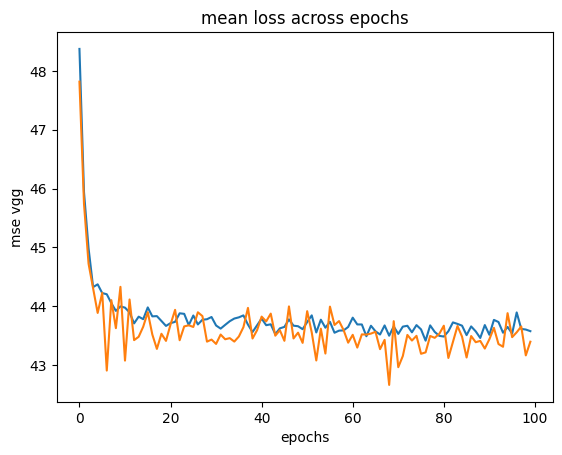

In [ ]:
from matplotlib import pyplot as plt
# htr_model.save("htr_model_vgg.keras")

plt.plot(epoch_loss, label = "training loss")
plt.plot(val_losses, label = "validation loss")
plt.xlabel("epochs")
plt.ylabel("mse vgg")
plt.title("mean loss across epochs")
plt.savefig("MeanvggEpochs.png", dpi=300, bbox_inches="tight")
plt.show()


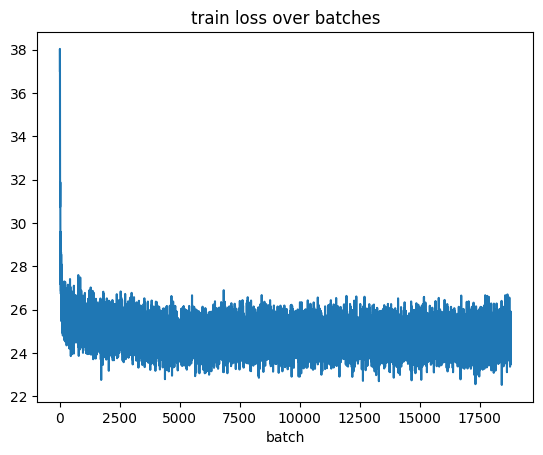

In [ ]:


plt.plot(all_batch_losses)
plt.xlabel("batch")
plt.title("train loss over batches")
plt.show()

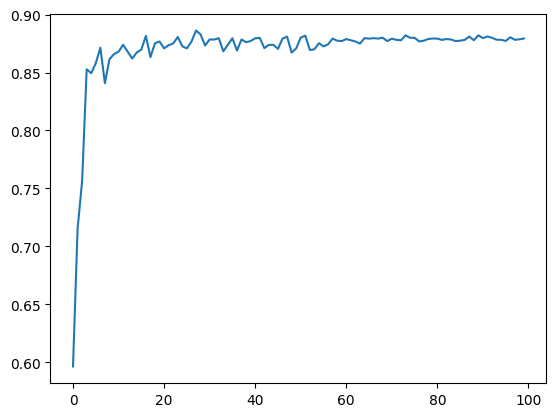

In [ ]:
plt.plot(accuracies)
plt.show()

In [ ]:
g_loss[-1]
accuracies[-1]

0.8793526785714285

In [ ]:
data = list(dataset.take(100))
images, one_hot_labels = data[0]

In [ ]:
images.shape

TensorShape([256, 28, 28, 1])

In [ ]:
pred_labels = htr_model(images[:5], training=False)
print(tf.one_hot(tf.argmax(pred_labels, axis=1), 10))
one_hot_labels[:5]

tf.Tensor(
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]], shape=(5, 10), dtype=float32)


<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)>

tf.Tensor([5], shape=(1,), dtype=int64) [[0.    0.002 0.    0.    0.    0.998 0.    0.    0.    0.   ]]
tf.Tensor([2], shape=(1,), dtype=int64) [[0.    0.079 0.819 0.06  0.    0.    0.002 0.038 0.    0.   ]]
tf.Tensor([1], shape=(1,), dtype=int64) [[0.    0.992 0.001 0.    0.    0.001 0.001 0.005 0.    0.   ]]
tf.Tensor([0], shape=(1,), dtype=int64) [[0.364 0.039 0.001 0.019 0.001 0.033 0.393 0.001 0.001 0.148]]
tf.Tensor([9], shape=(1,), dtype=int64) [[0.    0.003 0.    0.    0.001 0.    0.    0.002 0.    0.993]]
tf.Tensor([4], shape=(1,), dtype=int64) [[0.    0.013 0.    0.    0.977 0.    0.    0.002 0.    0.008]]
tf.Tensor([2], shape=(1,), dtype=int64) [[0.    0.003 0.986 0.002 0.    0.    0.    0.005 0.    0.004]]
tf.Tensor([8], shape=(1,), dtype=int64) [[0.    0.002 0.    0.    0.    0.003 0.    0.001 0.989 0.005]]
tf.Tensor([5], shape=(1,), dtype=int64) [[0.004 0.26  0.    0.    0.    0.727 0.    0.001 0.006 0.001]]
tf.Tensor([8], shape=(1,), dtype=int64) [[0.002 0.001 0.    0.00

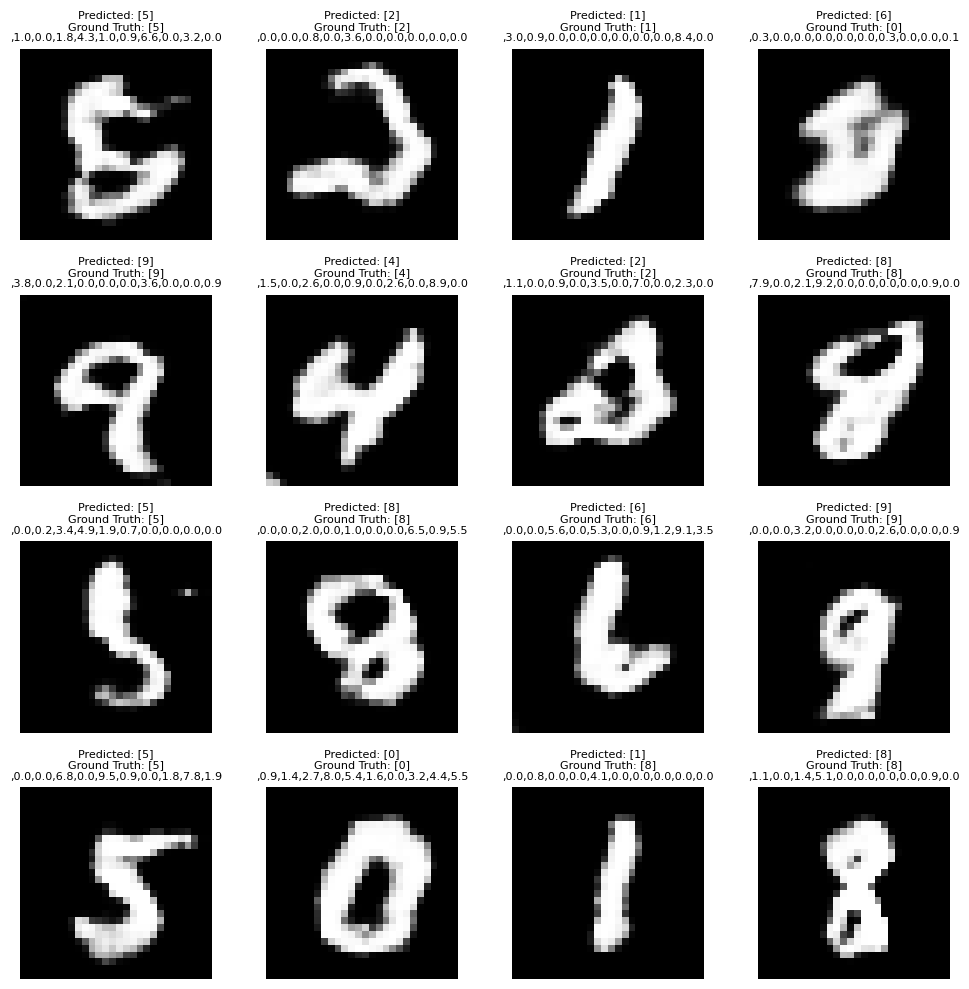

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a 4x4 grid of subplots
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

# Flatten the axs array to iterate over all subplots
axs = axs.flatten()

for i in range(16):
    pred = htr_model(images[i:(i+1)], training=False)

    pred_label = tf.argmax(pred, axis=1)
    
    gt_label = tf.argmax(one_hot_labels[i:(i+1)], axis=1)

    random_latent_vectors = tf.random.normal(
        shape=(1, latent_dim), seed=21
    )

    random_vector_labels = tf.concat(
        [random_latent_vectors, pred], axis=-1
    )
    gen_img = mnist_gen(random_vector_labels, training=False)
    # Plot image
    axs[i].imshow(tf.squeeze(gen_img), cmap='gray')
    axs[i].axis('off')  # Turn off axis
    
    # Add text above each pair of plots indicating predicted class and ground truth
    print(gt_label, np.round(pred.numpy(), 3))
    pred_str = ""
    for j in pred[0]:
        pred_str += "," + str(j.numpy())[:3]
    text = f'Predicted: {pred_label}\nGround Truth: {gt_label}\n' + pred_str
    axs[i].set_title(text, fontsize=8)

plt.tight_layout()
plt.show()


In [ ]:
def compute_accuracy(true_labels, predicted_labels):
    """
    Compute accuracy between true labels and predicted labels.

    Args:
    true_labels (list): List of true labels.
    predicted_labels (list): List of predicted labels.

    Returns:
    float: Accuracy as a value between 0 and 1.
    """
    if len(true_labels) != len(predicted_labels):
        raise ValueError("Length of true labels and predicted labels must be the same.")

    correct_predictions = sum(1 for true, pred in zip(true_labels, predicted_labels) if true == pred)
    total_samples = len(true_labels)

    accuracy = correct_predictions / total_samples if total_samples != 0 else 0

    return accuracy


In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(256)

acc = []
for batch in tqdm(test_dataset):
    images, one_hot_labels = batch
    preds = htr_model(images, training=False)
    pred_labels = tf.argmax(preds, axis=1)
    gt_labels = tf.argmax(one_hot_labels, axis=1)
    acc.append(compute_accuracy(gt_labels, pred_labels))

print("Accuracy: ", np.mean(acc)*100)

100%|██████████| 40/40 [00:10<00:00,  3.70it/s]

Accuracy:  89.16015625
